In [129]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## EDA

In [147]:
train_path = 'DATASET/TRAIN'
test_path = 'DATASET/TEST'
target_size = (150,150)

In [166]:
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in glob(category+'/*'):
        img = tf.keras.preprocessing.image.load_img(file)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

In [167]:
data['label'].value_counts()

O    12565
R     9999
Name: label, dtype: int64

In [171]:
x, y, c, max_pix, min_pix =  [], [], [], [], []
for image in data['image']:
    shape = image.shape
    x.append(shape[0])
    y.append(shape[1])
    c.append(shape[2])
    max_pix.append(np.max(image))
    min_pix.append(np.min(image))
data['width'], data['height'], data['color_channels'], data['max_pixel'], data['min_pixel'] = x, y, c, max_pix, min_pix

Text(0.5, 1.0, 'Class Distribution')

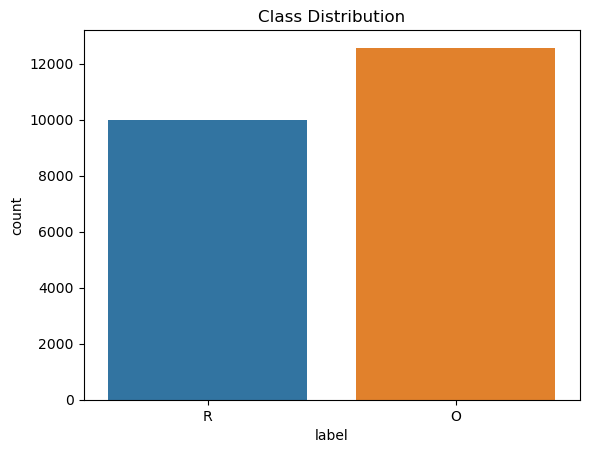

In [194]:
import seaborn as sns

sns.countplot(data=data, x='label').set_title('Class Distribution')

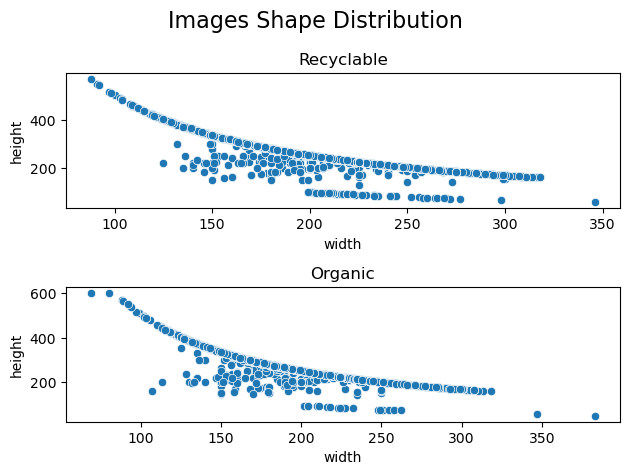

In [191]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)
fig.suptitle('Images Shape Distribution', fontsize=16)
sns.scatterplot(data=data[data['label'] == 'R'], x='width', y='height', ax=ax[0])
sns.scatterplot(data=data[data['label'] == 'O'], x='width', y='height', ax=ax[1])
ax[0].set_title('Recyclable')
ax[1].set_title('Organic')
fig.tight_layout()

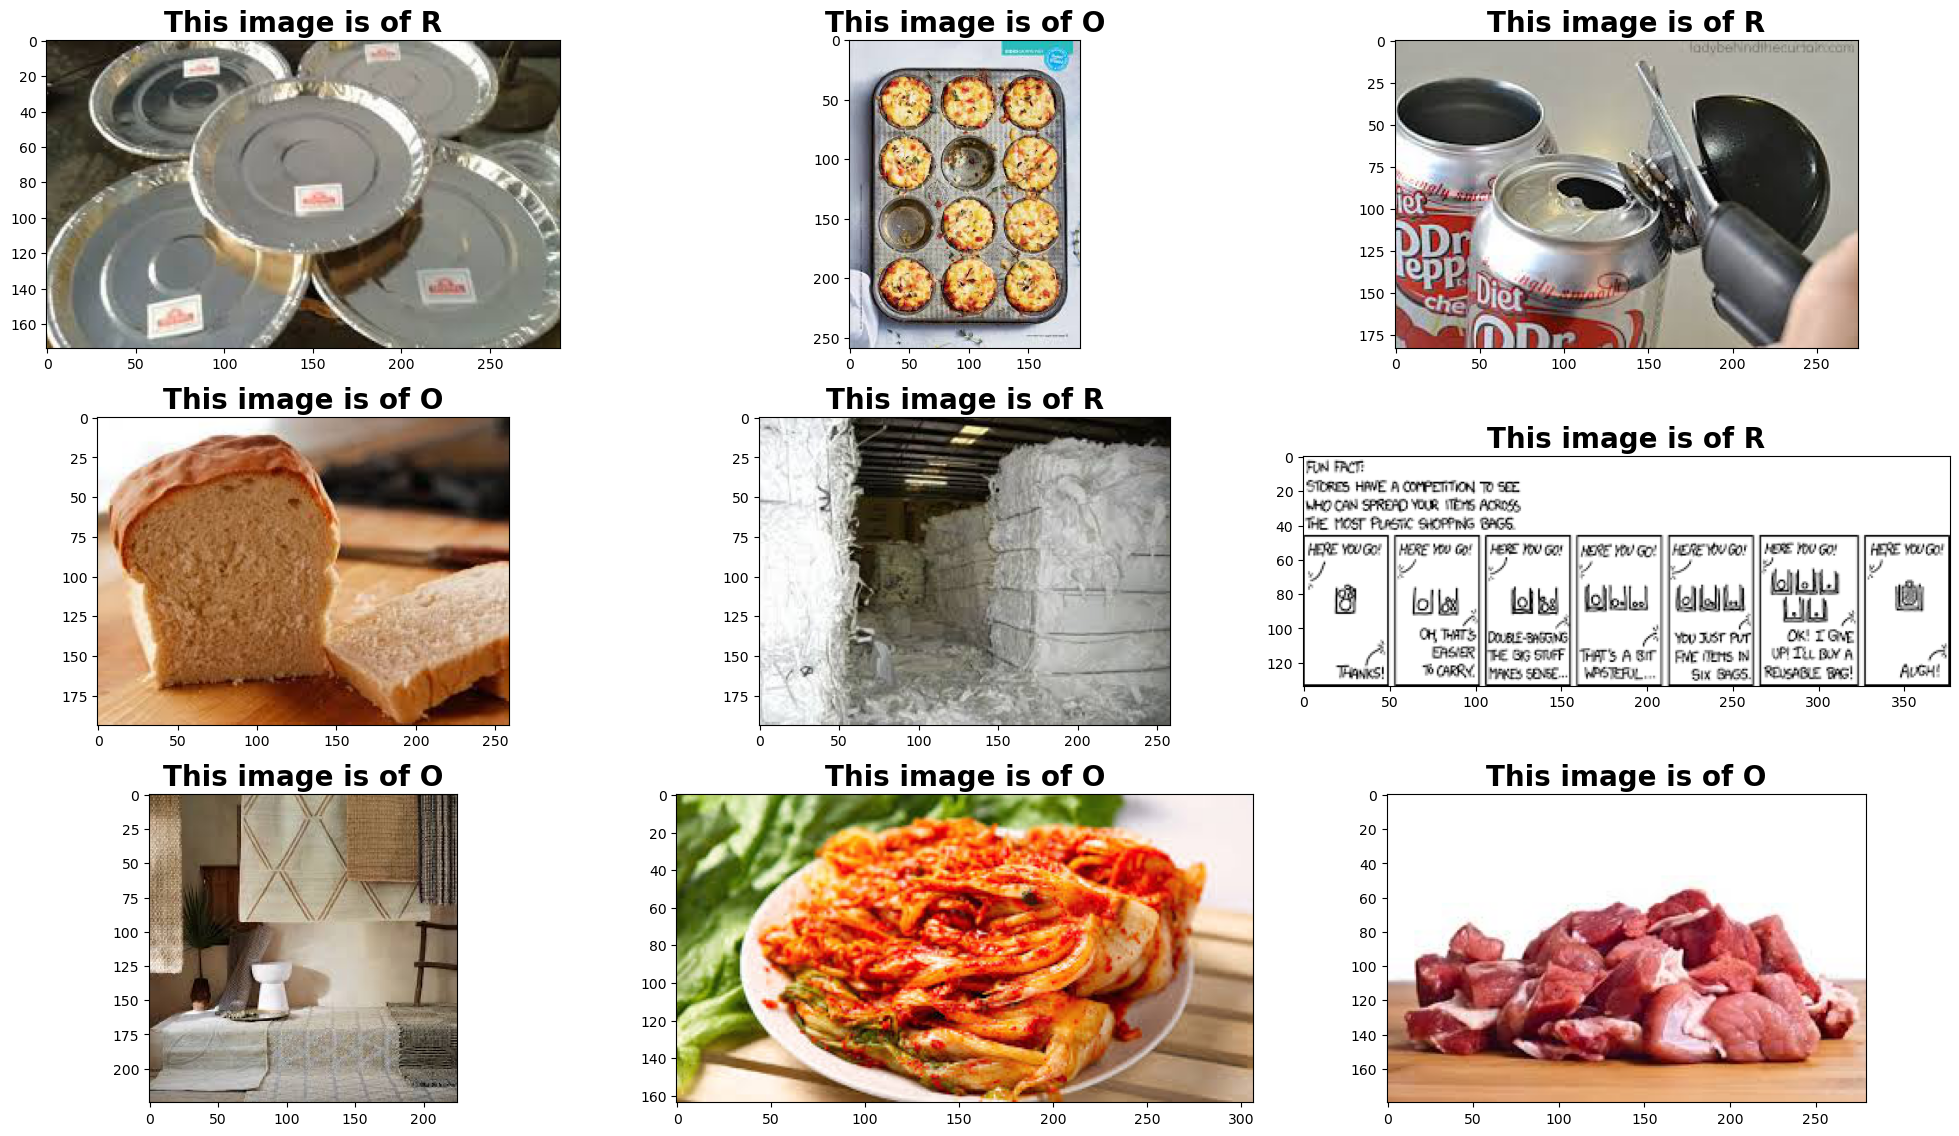

In [156]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(22000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(tf.keras.preprocessing.image.array_to_img(data.image[index]))
    plt.tight_layout()

## Model

In [142]:

train_gen = ImageDataGenerator(rescale=1/255)
test_gen = ImageDataGenerator(rescale=1/255)
train_data_generator = train_gen.flow_from_directory(train_path, target_size=target_size, class_mode='binary', batch_size=128)
test_data_generator = train_gen.flow_from_directory(test_path, target_size= target_size, class_mode='binary', batch_size=128)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [143]:
# class_names = train_data_generator.class_names
class_names = ['Organic', 'Recylable']

float32 (128, 224, 224, 3)
float32 (128,)


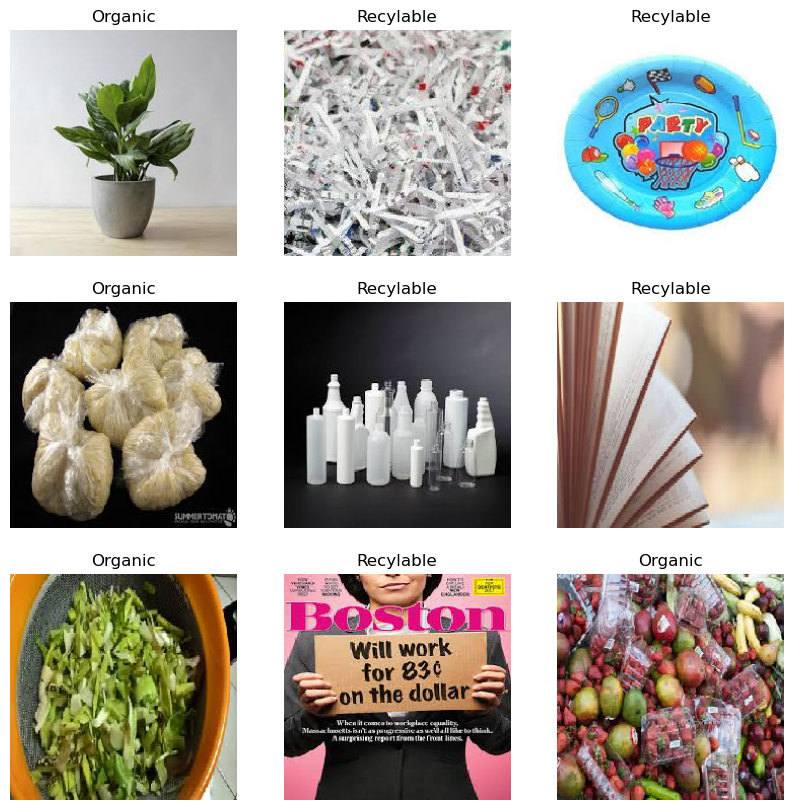

In [145]:
images, labels = next(train_data_generator)

print(images.dtype, images.shape)
print(labels.dtype, labels.shape)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [86]:
trained_model = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(150,150,3)
)
trained_model.trainable= False

In [87]:
model = tf.keras.models.Sequential([trained_model,
                                    # tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
                                    # tf.keras.layers.MaxPool2D(),
                                    # tf.keras.layers.Conv2D(264, (3,3), activation='relu'),
                                    # tf.keras.layers.MaxPool2D(),
                                    # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    # tf.keras.layers.MaxPool2D(),
                                    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    # tf.keras.layers.MaxPool2D(),
                                    # tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    # tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dropout(.2),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                    ])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_8 (Flatten)         (None, 51200)             0         
                                                                 
 dense_34 (Dense)            (None, 128)               6553728   
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 30,118,657
Trainable params: 6,553,857
Non-trainable params: 23,564,800
_________________________________________________________________


In [60]:

hist = model.fit(train_data_generator, epochs=5, validation_data=test_data_generator)

Epoch 1/5
177/177 [==============================] - 723s 4s/step - loss: 0.3809 - accuracy: 0.8997 - val_loss: 0.2759 - val_accuracy: 0.8886
Epoch 2/5
177/177 [==============================] - 748s 4s/step - loss: 0.1500 - accuracy: 0.9417 - val_loss: 0.2654 - val_accuracy: 0.8989
Epoch 3/5
177/177 [==============================] - 756s 4s/step - loss: 0.1034 - accuracy: 0.9585 - val_loss: 0.2758 - val_accuracy: 0.9125
Epoch 4/5
177/177 [==============================] - 753s 4s/step - loss: 0.0739 - accuracy: 0.9683 - val_loss: 0.3913 - val_accuracy: 0.8949
Epoch 5/5
177/177 [==============================] - 736s 4s/step - loss: 0.0571 - accuracy: 0.9750 - val_loss: 0.3891 - val_accuracy: 0.8945


In [83]:
model.save('resnet50_5epoch_v0.2.h5')
model.save('resnet50_5epoch_v0.1/')
model.save_weights('weightsv0.1.h5')

/Users/murali/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


KeyboardInterrupt: 

In [121]:

# images = np.vstack([x])
# test_data_generator = test_gen.flow_from_directory(test_path)

# test_data = tf.keras.preprocessing.image_dataset_from_directory(
#     test_path,
#     labels=None,
#     label_mode=None,
#     class_names=None,
#     color_mode="rgb",
#     batch_size=32,
#     image_size=(150, 150),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation="bilinear",
#     follow_links=False,
#     crop_to_aspect_ratio=False,
# )


loaded_model1 = tf.keras.models.load_model('resnet50_5epoch_v0.1.h5')
loaded_model2 = tf.keras.models.load_model('resnet50_5epoch_v0.2.h5')
loaded_model3 = tf.keras.models.load_model('resnet50_5epoch_v0.1')
loaded_model4 = model
loaded_model4.load_weights('weightsv0.1.h5')

In [125]:
test_path = 'DATASET/TRAIN/R/R_20.jpg'

# test_gen = ImageDataGenerator(rescale=1/255.)
img = tf.keras.utils.load_img(
    test_path,
    grayscale=False,
    color_mode='rgb',
    target_size=(150, 150),
    interpolation='nearest'
)

img_arr = tf.keras.utils.img_to_array(
    img 
)

img_arr = img_arr/255.
import numpy as np
x = np.expand_dims(img_arr, axis=0)

In [126]:
img_arr.shape, x.shape

((150, 150, 3), (1, 150, 150, 3))

In [127]:
predictions1 = loaded_model1.predict(x)
predictions2 = loaded_model2.predict(x)
predictions3 = loaded_model3.predict(x)
predictions4 = loaded_model4.predict(x)
predictions5 = model.predict(x)

In [128]:
import numpy as np
print(np.count_nonzero(predictions1>0.5), np.count_nonzero(predictions1<0.5))
print(np.count_nonzero(predictions2>0.5), np.count_nonzero(predictions2<0.5))
print(np.count_nonzero(predictions3>0.5), np.count_nonzero(predictions3<0.5))
print(np.count_nonzero(predictions4>0.5), np.count_nonzero(predictions4<0.5))
print(np.count_nonzero(predictions5>0.5), np.count_nonzero(predictions5<0.5))

1 0
0 1
1 0
1 0
1 0
